# IMDB

In [6]:
import pandas as pd
import numpy as np
import math
import random
from scipy.sparse import csr_matrix
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt
import matplotlib
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from seaborn import heatmap
import time

We start by preprossessing the data from the training set.

In [7]:
# Input
data_file = "aclImdb/train/labeledBow.feat"

# Delimiter
data_file_delimiter = ' '

# The max column count a line in the file could have
largest_column_count = 0

# Loop the data lines
with open(data_file, 'r') as temp_f:
   # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(data_file_delimiter)) + 1
        
        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

# Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
column_names = [i for i in range(0, largest_column_count)]

# Read csv
df = pd.read_csv(data_file, header=None, delimiter=data_file_delimiter, names=column_names, low_memory=False)
df = df.applymap(str)
df = df.replace(':', ',', regex=True)
df = df.replace('nan', '0', regex=True)

We need to transform the feature values of the form '0,9' for example into lists so that we can use the data to perform the experiment.

In [8]:
matrix = df.to_numpy()
rows, columns = matrix.shape
#convert the dataframe to a list of lists
n_matrix = matrix.tolist()
#loop over numpy array
for i in range(0, rows):
    n_matrix[i][0] = int(n_matrix[i][0])
    for j in range(1, columns): #skip the first column
        if "," in n_matrix[i][j]:
            l = n_matrix[i][j].split(",")
            x = int(l[0])
            y = int(l[1])
            n_matrix[i][j] = [x, y]


In [9]:
n_matrix = pd.DataFrame(n_matrix)
n_matrix[0] = n_matrix[0].astype(int)

Now, we can create a pandas DataFrame containing the index of the word and its frequency (whether it appears in a file).

In [10]:
#create a 89527 by 1 np.array containing index of the word and frequency of that word accross all reviews
array = np.empty([89527, 2])
n_matrix = n_matrix.values.tolist()

In [11]:
#now we iterate over the n_matrix and plug in the values
for x in range(0, rows):
    for y in range(1, columns):
        if type(n_matrix[x][y]) == list:
            l = n_matrix[x][y]
            word_idx = l[0]
            freq = array[word_idx][1]
            freq += 1
            array[word_idx][0] = word_idx
            array[word_idx][1] = freq
            

Now we want to get the frequency in percentage and we want the word instead of the index. We will be using imdb.vocab file for that part.

In [12]:
#we will put the vocab into an array.
with open("aclImdb/imdb.vocab", "r", encoding='utf-8') as f:
    data = f.readlines()

arr_word = [] 
for raw_word in data:
    word = raw_word.strip()
    arr_word.append(word)

In [13]:
#we'll change the array such that the index is replaced with the word and the freq are %
df_frequency = pd.DataFrame(columns=['Index', 'Word', 'frequency'], index=range(89527))

for x in range(0, 89527):
    df_frequency.loc[x][0] = array[x][0]
    df_frequency.loc[x][1] = arr_word[x]
    df_frequency.loc[x][2] = (array[x][1]/25000 * 100)

In [14]:
df_frequency

,Index,Word,frequency
0,0.0,the,99.168
1,1.0,and,96.648
2,2.0,a,96.692
3,3.0,of,94.888
4,4.0,to,93.836
...,...,...,...
89522,89522.0,copywrite,0.004
89523,89523.0,artbox,0.004
89524,89524.0,kinky-sex,0.004
89525,89525.0,urrrghhh,0.004


Now we remove the rare and stopwords (the words with a frequence of <1% or > 50%)

In [15]:
df_frequency_cleaned = df_frequency[(df_frequency.frequency >= 1) & (df_frequency.frequency <= 50)]
df_frequency_cleaned

,Index,Word,frequency
21,21.0,he,41.232
23,23.0,his,42.708
27,27.0,!,34.38
30,30.0,by,46.756
31,31.0,an,48.812
...,...,...,...
1935,1935.0,continues,1.008
1938,1938.0,below,1.016
1958,1958.0,opens,1.0
1967,1967.0,essentially,1.0


In [16]:
names = (df_frequency_cleaned['Word'].values.tolist())
names = names + ['Rating']
df_train = pd.DataFrame(columns=names, index=range(25000))

index = df_frequency_cleaned['Index'].values.tolist()
proper_idx = list(range(0, 1734))
#create a dictionary to know which word index corresponds to what column in df_train
idx_dict = dict(zip(index, proper_idx)) 

for x in range(0, rows):
    df_train.loc[x][1744] = n_matrix[x][0]
    for y in range(1, columns):
        if type(n_matrix[x][y]) == list:
            l = n_matrix[x][y]
            word_index = l[0]
            word_freq = l[1]
            if word_index in idx_dict:
                column = idx_dict.get(word_index)
                df_train.loc[x][column] = word_freq



In [17]:
df_train = df_train.fillna(0)
df_train

,he,his,!,by,an,who,they,from,so,like,...,portray,length,discovered,aware,continues,below,opens,essentially,received,Rating
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,1,0,0,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,7
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,10
4,0,0,0,1,1,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,5,0,9,3,1,7,3,2,1,0,...,0,0,0,0,0,0,0,0,0,1
24996,2,2,1,0,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,1
24997,0,2,0,2,1,2,3,1,0,3,...,0,0,0,0,0,0,0,0,0,4
24998,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [18]:
#ratings
y = df_train['Rating'].to_numpy()
y = csr_matrix(y)
y = (y.toarray()).flatten()

#Need to standardize y
mean = y.sum() / 25000
differences = [(value - mean) **2 for value in y]
sum_of_differences = sum(differences)
standard_deviation = (sum_of_differences / (25000 - 1)) ** 0.5
y_std = [(value - mean) / standard_deviation for value in y]

#reshape y to that it is 25000 X 1
y_std = np.array(y_std)
y_std = y_std.reshape((25000, 1))

In [19]:
#create empty z score array
z_scores = []
words = df_frequency_cleaned['Word'].values.tolist()


#loop for features 
for word in words:
    xT = df_train[word].to_numpy()
    
    xT = csr_matrix(xT)
    xT = (xT.toarray())
    #xT = xT.flatten()
    #print(xT)
    
    #Need to standardize x
    mean = xT.sum() / 25000
    
    differences = [(value - mean) **2 for value in xT]
    
    sum_of_differences = sum(differences)
    sum_of_differences = sum(sum_of_differences)
    standard_deviation = (sum_of_differences / (25000 - 1)) ** 0.5
    try:
        xT_std = [(value - mean) / standard_deviation for value in xT]
    except:
        xT_std.append(0)
        
    xT_std =  np.array(xT_std).flatten()
    #calculate z-score
    z = np.matmul(xT_std,y_std)/math.sqrt(1744)
    z_scores.append(z)
    
z_scores = np.array(z_scores).flatten()

<ipython-input-19-faa160bf15c3>:24: RuntimeWarning: invalid value encountered in true_divide
  xT_std = [(value - mean) / standard_deviation for value in xT]


Now we want to associate the z-scores with their respective words such that we will be able to choose the features.

In [20]:
df_frequency_cleaned.reset_index(drop=True, inplace=True)
df_zscore = pd.DataFrame({'Word': df_frequency_cleaned['Word'], 'Z-score': z_scores }, index=range(1744))
df_zscore = df_zscore.fillna(0)
df_zscore

,Word,Z-score
0,he,23.687438
1,his,51.961402
2,!,-3.963261
3,by,26.202532
4,an,19.397143
...,...,...
1739,continues,0.000000
1740,below,0.000000
1741,opens,0.000000
1742,essentially,0.000000


In [21]:
df_train_negative = df_zscore.nsmallest(n=150, columns=['Z-score'])
df_train_positive = df_zscore.nlargest(n=150, columns=['Z-score'])

negative = df_train_negative['Word'].values.tolist()
positive = df_train_positive['Word'].values.tolist()
features = negative + positive
features.append('Rating')

df_train = df_train.filter(items = features, axis =1)
df_train.set_axis([*df_train.columns[:-1], 'Label'], axis=1, inplace=True)
neg = df_train['Label'] <= 4
df_train.loc[neg, 'Label'] = 0
pos = df_train['Label'] >= 7
df_train.loc[pos, 'Label'] = 1
df_train

,bad,worst,waste,awful,?,terrible,worse,no,horrible,stupid,...,impressed,genius,loving,appreciate,age,believable,available,him,us,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3,0,0,0,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24997,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24998,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we process the test data

In [22]:
# Input
data_file = "aclImdb/test/labeledBow.feat"

# Delimiter
data_file_delimiter = ' '

# The max column count a line in the file could have
largest_column_count = 0

# Loop the data lines
with open(data_file, 'r') as temp_f:
   # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(data_file_delimiter)) + 1
        
        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

# Generate column names (will be 0, 1, 2, ..., largest_column_count - 1)
column_names = [i for i in range(0, largest_column_count)]

# Read csv
df = pd.read_csv(data_file, header=None, delimiter=data_file_delimiter, names=column_names, low_memory = False)
df = df.applymap(str)
df = df.replace(':', ',', regex=True)
df = df.replace('nan', '0', regex=True)

In [23]:
t_matrix = df.to_numpy()
rows, columns = t_matrix.shape
#convert the dataframe to a list of lists
t_matrix = t_matrix.tolist()
#loop over numpy array
for i in range(0, rows):
    t_matrix[i][0] = int(t_matrix[i][0])
    for j in range(1, columns): #skip the first column
        if "," in t_matrix[i][j]:
            l = t_matrix[i][j].split(",")
            x = int(l[0])
            y = int(l[1])
            t_matrix[i][j] = [x, y]
t_matrix = pd.DataFrame(t_matrix)
t_matrix[0] = t_matrix[0].astype(int)

In [24]:
names = (df_frequency_cleaned['Word'].values.tolist())
names = names + ['Rating']
df_test = pd.DataFrame(columns=names, index=range(25000))

for x in range(0, 25000):
    df_test.loc[x][1744] = t_matrix[0][x]
    for y in range(1, 933):
        if type(t_matrix[y][x]) == list:
            l = t_matrix[y][x]
            word_index = l[0]
            word_freq = l[1]
            if word_index in idx_dict:
                column = idx_dict.get(word_index)
                df_test.loc[x][column] = word_freq

df_test = df_test.fillna(0)

df_test = df_test.filter(items = features, axis =1)
df_test.set_axis([*df_test.columns[:-1], 'Label'], axis=1, inplace=True)
neg = df_test['Label'] <= 4
df_test.loc[neg, 'Label'] = 0
pos = df_test['Label'] >= 7
df_test.loc[pos, 'Label'] = 1
df_test

,bad,worst,waste,awful,?,terrible,worse,no,horrible,stupid,...,impressed,genius,loving,appreciate,age,believable,available,him,us,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,2,0,1
3,2,0,0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2,0,1,0,2,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,0
24996,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24998,0,1,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,2,0,0


In [25]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    
    def fit(self, x, y, learning_rate, max_iters):
        self.learning_rate = learning_rate
        self.max_iters = max_iters 
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

# LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

Data ratio: 20% training and 80% testing

In [26]:
train_subset = df_train.sample(frac=0.2)
X_train = train_subset.drop(["Label"], axis=1).values
y_train = train_subset["Label"].values

test_subset = df_test.sample(frac=0.8)
X_test = test_subset.drop(["Label"], axis=1).values
y_test = test_subset["Label"].values

In [27]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

X_train = StandardScaler().fit(X_train).transform(X_train)
X_test = StandardScaler().fit(X_test).transform(X_test)

 
logitreg = LogisticRegression()
fit = logitreg.fit(X_train, y_train, max_iters=1000, learning_rate = 0.00005)
effect_size = pd.DataFrame(fit.w[:(len(fit.w)-1)]).transpose() # linear coefficents
effect_size.shape
effect_size.columns = df_train.drop(["Label"], axis=1).columns

<Figure size 432x288 with 0 Axes>

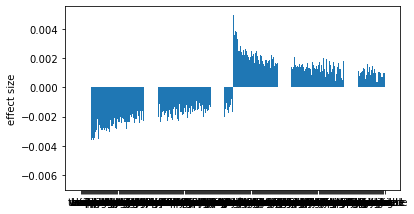

In [28]:
plt.clf()
plt.figure(figsize=(6, 6/(16/9)))
plt.bar(list(effect_size.columns.values), effect_size.stack().tolist())
plt.ylabel("effect size")
# plt.show()
plt.savefig("effect_size.png", bbox_inches='tight', dpi=300)

In [29]:
y_train_pred = fit.predict(X_train)
y_test_pred = fit.predict(X_test)

# threshold probabilities
y_train_pred = (y_train_pred > 0.5).astype(int)
y_test_pred = (y_test_pred > 0.5).astype(int)

# accuracy = correctly classified / total classified
acc_train = sum(y_train_pred==y_train)/len(y_train)
acc_test = sum(y_test_pred==y_test)/len(y_test)
print(f"train accuracy: {acc_train:.3f}; test accuracy: {acc_test:.3f}")

train accuracy: 0.829; test accuracy: 0.820


Horizontal bar plot showing the top 20 features (10 most positive and 10 most negative) with the z-scores as the x-axis and the feature names as the y-axis. 

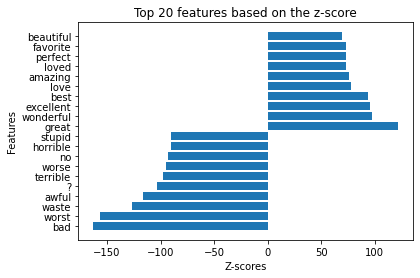

In [30]:
df_train_negative = df_zscore.nsmallest(n=10, columns=['Z-score'])
df_train_positive = df_zscore.nlargest(n=10, columns=['Z-score'])

negative = df_train_negative['Word'].values.tolist()
positive = df_train_positive['Word'].values.tolist()
words = negative + positive

zscores_neg = df_train_negative['Z-score'].values.tolist()
zscores_pos = df_train_positive['Z-score'].values.tolist()
zscores = zscores_neg + zscores_pos

plt.barh(words, zscores)
plt.ylabel("Features")
plt.xlabel("Z-scores")
plt.title("Top 20 features based on the z-score")
plt.show()

ROC curve

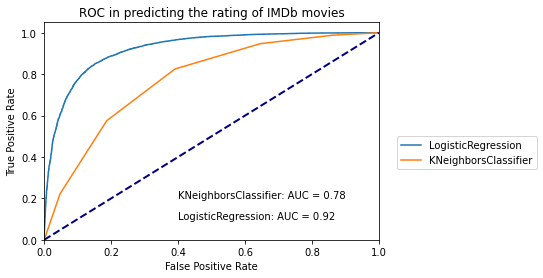

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

perf = {}

# our implementation is slow you may try sklearn version
logitreg = LogisticRegression()
fit = logitreg.fit(X_train, y_train, max_iters=1e3, learning_rate = .1)
y_test_prob = fit.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
auroc = roc_auc_score(y_test, y_test_prob)
perf["LogisticRegression"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}


fit = model.fit(X_train, y_train)
y_test_prob = fit.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
auroc = roc_auc_score(y_test, y_test_prob)
perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting the rating of IMDb movies')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()

Bar plot showing the AUROC of logistic regression and KNN on the test data (y-axis) as a function of the 20%, 40%, 60%, 80%, and 100% training data (x-axis)

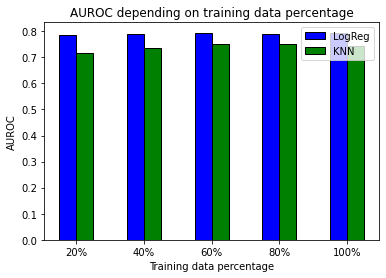

In [32]:
percentage_train = [0.2, 0.4, 0.6, 0.8]
auroc_LG = []
auroc_KNN = []

for percentage in percentage_train:
    train_subset = df_train.sample(frac=percentage)
    X_train = train_subset.drop(["Label"], axis=1).values
    y_train = train_subset["Label"].values

    test_subset = df_test.sample(frac=(1-percentage))
    X_test = test_subset.drop(["Label"], axis=1).values
    y_test = test_subset["Label"].values

    # Our implementation
    logitreg = LogisticRegression()
    fit = logitreg.fit(X_train, y_train, max_iters=1e3, learning_rate = 0.00005)
    y_test_prob = fit.predict(X_test)
    auroc_lg = roc_auc_score(y_test, y_test_prob)
    auroc_LG.append(auroc_lg)
    # KNN
    fit = model.fit(X_train, y_train)
    y_test_prob = fit.predict_proba(X_test)[:,1]
    auroc_knn = roc_auc_score(y_test, y_test_prob)
    auroc_KNN.append(auroc_knn)


# 100% training 
train_subset = df_train.sample(frac=1)
X = train_subset.drop(["Label"], axis=1).values
y = train_subset["Label"].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.2, random_state=1, shuffle=True)

# Our implementation
logitreg = LogisticRegression()
fit = logitreg.fit(X_train, y_train, max_iters=1e3, learning_rate = 0.00005)
y_test_prob = fit.predict(X_test)
auroc_lg = roc_auc_score(y_test, y_test_prob)
auroc_LG.append(auroc_lg)
# KNN
fit = model.fit(X_train, y_train)
y_test_prob = fit.predict_proba(X_test)[:,1]
auroc_knn = roc_auc_score(y_test, y_test_prob)
auroc_KNN.append(auroc_knn)

percentage_train.append(1)

n=5
r = np.arange(n)
width = 0.25
  
plt.bar(r, auroc_LG, color = 'b',
        width = width, edgecolor = 'black',
        label='LogReg')
plt.bar(r + width, auroc_KNN, color = 'g',
        width = width, edgecolor = 'black',
        label='KNN')
  
plt.xlabel("Training data percentage")
plt.ylabel("AUROC")
plt.title("AUROC depending on training data percentage")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,['20%','40%','60%','80%', '100%'])
plt.legend()
  
plt.show()

Checking gradient using small perturbation

In [33]:
X = df_train.drop(["Label"], axis=1).values
x = X
y = y.reshape((25000, 1))

# small perturbation
w = np.random.randn(1)
w0 = w
epsilon = np.random.randn(1)[0] * 1e-5
w1 = w0 + epsilon
w2 = w0 - epsilon
a1 = w1*x
a2 = w2*x
ce1 = np.sum(y * np.log1p(np.exp(-a1)) + (1-y) * np.log1p(np.exp(a1)))
ce2 = np.sum(y * np.log1p(np.exp(-a2)) + (1-y) * np.log1p(np.exp(a2)))
dw_num = (ce1 - ce2)/(2*epsilon) # approximated gradient

yh = 1/(1+np.exp(-x * w))
dw_cal = np.sum((yh - y) * x) # hand calculated gradient

print(dw_cal)
print(dw_num)
print((dw_cal - dw_num)**2/(dw_cal + dw_num)**2)

199604.80690591538
199604.80587869318
6.621049148397399e-18


Cross-entropy as a function of iteration

In [34]:
X = df_train.drop(["Label"], axis=1).values

train_subset = df_train
X_train = train_subset.drop(["Label"], axis=1).values
X_train = TfidfTransformer().fit(X_train).transform(X_train)
x = X_train.toarray()

y_train = train_subset["Label"].values
y = y_train.reshape((25000, 1))
# monitor loss
lr = 0.00005
niter = 100
ce_all = np.zeros(niter)
ce_all = np.array(ce_all, dtype = np.longdouble)
w = np.random.randn(1)
w0 = w

for i in range(niter):
    a = w * x
    ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))) # cross-entropy
    #print(ce_all[i])
    y_hat = 1 / (1 + np.exp(-a))
    dw = np.sum((y_hat - y) * x)
    w = w - lr * dw



<Figure size 432x288 with 0 Axes>

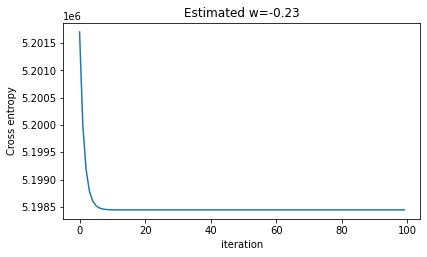

In [35]:
plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(ce_all)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
# plt.title(f"True w={w_true}; Estimated w={round(w.astype(float)[0],2)}")
plt.title(f"Estimated w={round(w[0],2)}")
# plt.show()
plt.savefig('ce_iteration.png', bbox_inches="tight", dpi=300)

In [71]:
X = df_train.drop(["Label"], axis=1).values

train_subset = df_train
X_train = train_subset.drop(["Label"], axis=1).values
X_train = TfidfTransformer().fit(X_train).transform(X_train)
x = X_train.toarray()

y_train = train_subset["Label"].values
y = y_train.reshape((25000, 1))
# monitor loss
lr = 0.05
niter = 1000
ce_all = np.zeros(niter)
ce_all = np.array(ce_all, dtype = np.longdouble)
w = np.random.randn(1)
w0 = w

for i in range(niter):
    a = w * x
    ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))) # cross-entropy
    #print(ce_all[i])
    y_hat = 1 / (1 + np.exp(-a))
    dw = np.sum((y_hat - y) * x)
    w = w - lr * dw


<ipython-input-71-fd3dee389e52>:20: RuntimeWarning: overflow encountered in exp
  ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))) # cross-entropy
<ipython-input-71-fd3dee389e52>:20: RuntimeWarning: invalid value encountered in multiply
  ce_all[i] = np.sum(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a))) # cross-entropy
<ipython-input-71-fd3dee389e52>:22: RuntimeWarning: overflow encountered in exp
  y_hat = 1 / (1 + np.exp(-a))


<Figure size 432x288 with 0 Axes>

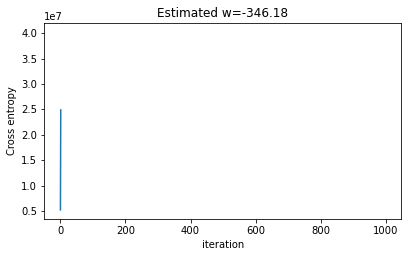

In [72]:
plt.clf()
plt.figure(figsize=((16/9)*3.6,3.6))
plt.plot(ce_all)
plt.ylabel("Cross entropy")
plt.xlabel("iteration")
# plt.title(f"True w={w_true}; Estimated w={round(w.astype(float)[0],2)}")
plt.title(f"Estimated w={round(w[0],2)}")
# plt.show()
plt.savefig('ce_iteration.png', bbox_inches="tight", dpi=300)

Calculating the weights for feature (coefficients)

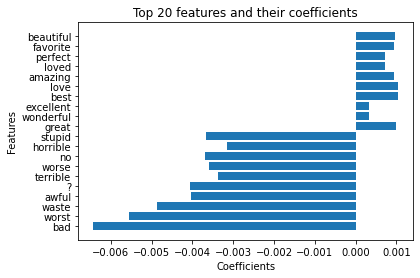

In [38]:
w_our_model = effect_size.values[0]
neg_w = w_our_model[:10]
pos_w = w_our_model[-10:]
features_coeff = np.concatenate((neg_w, pos_w), axis=0)

plt.barh(words, features_coeff)
plt.ylabel("Features")
plt.xlabel("Coefficients")
plt.title("Top 20 features and their coefficients")
plt.show()

In [39]:
features_coeff

array([-0.00642932, -0.00555851, -0.00487173, -0.00403158, -0.00405429,
       -0.00337485, -0.00360155, -0.00368052, -0.00314143, -0.0036619 ,
        0.00099255,  0.00034128,  0.00033316,  0.00103705,  0.00103067,
        0.00094405,  0.00073128,  0.0007143 ,  0.00095648,  0.00097384])

Feature selection with Lasso regression (code based on the following website: https://www.yourdatateacher.com/2021/05/05/feature-selection-in-machine-learning-using-lasso-regression/)

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [117]:
train_subset = df_train.sample(frac=0.2)
X_train = train_subset.drop(["Label"], axis=1)
y_train = train_subset["Label"]

test_subset = df_test.sample(frac=0.8)
X_test = test_subset.drop(["Label"], axis=1)
y_test = test_subset["Label"]

df_train_negative = df_zscore.nsmallest(n=150, columns=['Z-score'])
df_train_positive = df_zscore.nlargest(n=150, columns=['Z-score'])

negative = df_train_negative['Word'].values.tolist()
positive = df_train_positive['Word'].values.tolist()
features_lasso = negative + positive

In [118]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [119]:
search.fit(X_train,y_train)
search.best_params_
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print(importance)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 2/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 3/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 4/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 5/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 1/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 2/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 3/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 4/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 5/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 1/5] END ...............model__alpha=0.30000000000000004; total time=   0.0s
[CV 2/5] END ...............model__alpha=0.3000

[CV 4/5] END ...............................model__alpha=2.1; total time=   0.0s
[CV 5/5] END ...............................model__alpha=2.1; total time=   0.0s
[CV 1/5] END ...............................model__alpha=2.2; total time=   0.0s
[CV 2/5] END ...............................model__alpha=2.2; total time=   0.0s
[CV 3/5] END ...............................model__alpha=2.2; total time=   0.0s
[CV 4/5] END ...............................model__alpha=2.2; total time=   0.0s
[CV 5/5] END ...............................model__alpha=2.2; total time=   0.0s
[CV 1/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 2/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 3/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 4/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 5/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END ...............................model__alpha=4.2; total time=   0.0s
[CV 2/5] END ...............................model__alpha=4.2; total time=   0.0s
[CV 3/5] END ...............................model__alpha=4.2; total time=   0.0s
[CV 4/5] END ...............................model__alpha=4.2; total time=   0.0s
[CV 5/5] END ...............................model__alpha=4.2; total time=   0.0s
[CV 1/5] END ...............................model__alpha=4.3; total time=   0.0s
[CV 2/5] END ...............................model__alpha=4.3; total time=   0.0s
[CV 3/5] END ...............................model__alpha=4.3; total time=   0.0s
[CV 4/5] END ...............................model__alpha=4.3; total time=   0.0s
[CV 5/5] END ...............................model__alpha=4.3; total time=   0.0s
[CV 1/5] END ................model__alpha=4.3999999999999995; total time=   0.0s
[CV 2/5] END ................model__alpha=4.3999999999999995; total time=   0.0s
[CV 3/5] END ...............

[CV 5/5] END ...............................model__alpha=6.2; total time=   0.0s
[CV 1/5] END ...............................model__alpha=6.3; total time=   0.0s
[CV 2/5] END ...............................model__alpha=6.3; total time=   0.0s
[CV 3/5] END ...............................model__alpha=6.3; total time=   0.0s
[CV 4/5] END ...............................model__alpha=6.3; total time=   0.0s
[CV 5/5] END ...............................model__alpha=6.3; total time=   0.0s
[CV 1/5] END ...............................model__alpha=6.4; total time=   0.0s
[CV 2/5] END ...............................model__alpha=6.4; total time=   0.0s
[CV 3/5] END ...............................model__alpha=6.4; total time=   0.0s
[CV 4/5] END ...............................model__alpha=6.4; total time=   0.0s
[CV 5/5] END ...............................model__alpha=6.4; total time=   0.0s
[CV 1/5] END ...............................model__alpha=6.5; total time=   0.0s
[CV 2/5] END ...............

[CV 2/5] END ...............................model__alpha=8.3; total time=   0.0s
[CV 3/5] END ...............................model__alpha=8.3; total time=   0.0s
[CV 4/5] END ...............................model__alpha=8.3; total time=   0.0s
[CV 5/5] END ...............................model__alpha=8.3; total time=   0.0s
[CV 1/5] END ...............................model__alpha=8.4; total time=   0.0s
[CV 2/5] END ...............................model__alpha=8.4; total time=   0.0s
[CV 3/5] END ...............................model__alpha=8.4; total time=   0.0s
[CV 4/5] END ...............................model__alpha=8.4; total time=   0.0s
[CV 5/5] END ...............................model__alpha=8.4; total time=   0.0s
[CV 1/5] END ...............................model__alpha=8.5; total time=   0.0s
[CV 2/5] END ...............................model__alpha=8.5; total time=   0.0s
[CV 3/5] END ...............................model__alpha=8.5; total time=   0.0s
[CV 4/5] END ...............

In [120]:
np.array(features_lasso)[importance > 0]

array(['bad', 'worst', 'great'], dtype='<U14')

In [122]:
np.array(features_lasso)[importance == 0]

array(['waste', 'awful', '?', 'terrible', 'worse', 'no', 'horrible',
       'stupid', 'boring', 'crap', 'even', 'nothing', 'poor', 'minutes',
       'avoid', 'acting', 'supposed', 'ridiculous', 'plot', 'just',
       'money', 'poorly', 'lame', 'pointless', "don't", 'script', 'why',
       'pathetic', 'wasted', 'annoying', 'thing', 'garbage', 'oh', 'mess',
       'badly', 'laughable', 'redeeming', 'any', 'unless', 'least',
       "couldn't", 'make', 'instead', 'cheap', 'if', 'save', 'there',
       'dull', 'excuse', 'could', 'reason', 'or', 'only', 'anything',
       'joke', 'predictable', 'mean', 'bother', 'guy', 'sucks', 'fails',
       'attempt', 'guess', 'dumb', "didn't", 'like', 'they', 'then',
       'sorry', 'do', 'whatsoever', "i'm", 'low', 'decent', 'would',
       'trash', 'bunch', 'looks', 'someone', 'seriously', 'off', 'better',
       'apparently', "wasn't", 'fake', 'rubbish', 'unfortunately', 'so',
       'ok', 'wooden', 'failed', 'actually', 'painful', 'wrong', 'idea',
  

In [92]:
pd.DataFrame(data['estimators'][1][1].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.906033,0.296069,0.009667,0.001989,0.0,{'alpha': 0.0},-0.327023,-0.333901,-0.335520,-0.321448,-0.312770,-0.316874,-0.320797,-0.342386,-0.321157,-0.314289,-0.324616,0.009328,1
1,0.094388,0.005660,0.007882,0.001111,0.01,{'alpha': 0.01},-0.392008,-0.393719,-0.407878,-0.387873,-0.383416,-0.400674,-0.391769,-0.400932,-0.384368,-0.389807,-0.393244,0.007406,2
2,0.086030,0.010052,0.008579,0.001314,0.02,{'alpha': 0.02},-0.428723,-0.427754,-0.437386,-0.427843,-0.422584,-0.434090,-0.423961,-0.431549,-0.420560,-0.421975,-0.427643,0.005238,3
3,0.084002,0.010266,0.009614,0.003235,0.03,{'alpha': 0.03},-0.448338,-0.447896,-0.453328,-0.447007,-0.443180,-0.449786,-0.439796,-0.447652,-0.442506,-0.441514,-0.446100,0.003994,4
4,0.076653,0.011291,0.007912,0.000895,0.04,{'alpha': 0.04},-0.462512,-0.458701,-0.463903,-0.460319,-0.456095,-0.460038,-0.452130,-0.459044,-0.457175,-0.454645,-0.458456,0.003380,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.059589,0.008628,0.008700,0.003767,0.95,{'alpha': 0.9500000000000001},-0.500168,-0.500232,-0.499943,-0.500061,-0.500019,-0.500168,-0.499983,-0.500061,-0.499915,-0.499983,-0.500053,0.000100,14
96,0.056941,0.007659,0.009366,0.005736,0.96,{'alpha': 0.96},-0.500168,-0.500232,-0.499943,-0.500061,-0.500019,-0.500168,-0.499983,-0.500061,-0.499915,-0.499983,-0.500053,0.000100,14
97,0.056613,0.010309,0.006836,0.000722,0.97,{'alpha': 0.97},-0.500168,-0.500232,-0.499943,-0.500061,-0.500019,-0.500168,-0.499983,-0.500061,-0.499915,-0.499983,-0.500053,0.000100,14
98,0.057918,0.010888,0.007776,0.002066,0.98,{'alpha': 0.98},-0.500168,-0.500232,-0.499943,-0.500061,-0.500019,-0.500168,-0.499983,-0.500061,-0.499915,-0.499983,-0.500053,0.000100,14


In [93]:
import matplotlib.pyplot as plt
from textwrap import wrap

def rf_feat_importance(model, df):
    importance = model.coef_
    keys = list(df.keys())
    # summarize feature importance
    for i,v in enumerate(importance):
      print('Feature: %s, Score: %.5f' % (keys[i],v))
  
    labels =[x[:10] for x in keys]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar([x for x in range(len(importance))], height=importance, color='b')
    ax.set_xticklabels([labels[i - 1] for i in range(len(importance) +1)], rotation=45)

    plt.show()
    return importance

Feature: bad, Score: -0.04606
Feature: worst, Score: -0.10085
Feature: waste, Score: -0.12720
Feature: awful, Score: -0.10010
Feature: ?, Score: -0.02054
Feature: terrible, Score: -0.05992
Feature: worse, Score: -0.02736
Feature: no, Score: -0.00849
Feature: horrible, Score: -0.06330
Feature: stupid, Score: -0.03461
Feature: boring, Score: -0.04529
Feature: crap, Score: -0.02400
Feature: even, Score: -0.02174
Feature: nothing, Score: -0.03917
Feature: poor, Score: -0.07363
Feature: minutes, Score: -0.02331
Feature: avoid, Score: -0.06939
Feature: acting, Score: 0.00122
Feature: supposed, Score: -0.02397
Feature: ridiculous, Score: -0.04303
Feature: plot, Score: -0.04393
Feature: just, Score: -0.01050
Feature: money, Score: -0.02163
Feature: poorly, Score: -0.09620
Feature: lame, Score: -0.11552
Feature: pointless, Score: -0.11044
Feature: don't, Score: 0.00178
Feature: script, Score: -0.02205
Feature: why, Score: 0.00350
Feature: pathetic, Score: -0.04235
Feature: wasted, Score: -0.120

<ipython-input-93-a93ff8bf0b28>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([labels[i - 1] for i in range(len(importance) +1)], rotation=45)


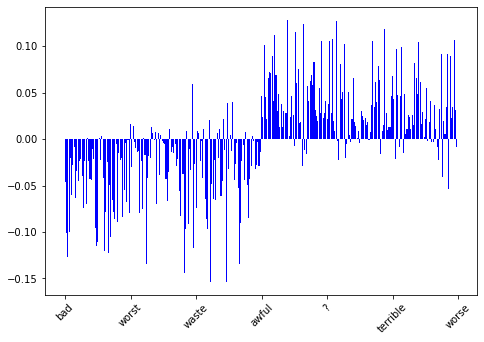

In [95]:
importance = rf_feat_importance(data['estimators'][1][1].best_estimator_, X_train)

In [96]:
for ind, column in enumerate(X_train.columns):
    if importance[ind] == 0:
        X_train.drop(column, axis=1, inplace = True)
        X_test.drop(column, axis=1, inplace = True)

In [97]:
X_train

,bad,worst,waste,awful,?,terrible,worse,no,horrible,stupid,...,meets,impressed,genius,loving,appreciate,age,believable,available,him,us
22166,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13022,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
23636,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8946,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2005,0,0,0,0,2,0,1,2,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16935,0,0,0,3,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21717,1,0,1,0,0,0,0,2,0,1,...,0,0,0,0,0,0,0,0,0,0
7987,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


# 20 news groups: a multi-class labelled textual dataset

In [42]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import mutual_info_score
from matplotlib import pyplot as plt
import matplotlib
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from seaborn import heatmap
import numpy as np
import time

In [43]:
categories = ['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']
dataset = fetch_20newsgroups(subset='train', remove=(['headers', 'footers', 'quotes']), categories=categories)
len(dataset.target)


2377

The order in which the target names are listed below is the same order the targets are in. If the first entry below is 'comp.graphics', then target 0 refers to it.

In [44]:
dataset.target_names

['comp.graphics', 'rec.sport.hockey', 'sci.med', 'soc.religion.christian']

Let's hot-encode the labels

In [45]:
y_all = np.zeros((len(dataset.target), len(dataset.target_names)))
for i in range(len(dataset.target)):
    y_all[i][dataset.target[i]] = 1

print(y_all)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


Got rid of stop words and rare words.

In [46]:
count_vect = CountVectorizer(max_df = 0.5, min_df = 0.01)
sparse_x_all = count_vect.fit_transform(dataset.data)
features = count_vect.get_feature_names()
x_all = sparse_x_all.toarray()
print(features[626])

graphics


Try transforming the data using tf/tf-idf

In [47]:
sparse_x_tf = TfidfTransformer().fit_transform(sparse_x_all)
x_tf = sparse_x_tf.toarray()

In [48]:
print(x_all)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 3 0 0]
 [0 0 6 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Calculate the MI score of each word compared to each label and store it. I'm looping but I'm sure there's a more efficient way to do this. We use occurences instead of term frequencies because the mutual_info_score function requires discrete values

In [49]:
mi_scores = np.zeros((y_all.shape[1], x_all.shape[1]))

for y_ind in range(y_all.shape[1]):
    for x_ind in range(x_all.shape[1]):
        mi_scores[y_ind][x_ind] = mutual_info_score(y_all[:, y_ind], x_all[:, x_ind])

mi_scores.shape

(4, 1586)

In [50]:
features[1382]

'team'

In [51]:
topind = np.argsort(mi_scores, axis=1)[:,-100:]
topind

array([[ 103,  726,  888, 1096,  844,  931, 1427, 1211,  434,  110,  974,
        1230,  306,  102,  588,  183, 1549,  896,  832, 1537,  111,  651,
        1227,  578,  426,  818, 1525, 1253,  254, 1476,  414,  322, 1056,
        1581, 1095,   99,  597,  206,  256, 1471,  303, 1415,   23,  649,
        1483,  305,  223, 1223, 1493,  214,  972,  647,  321, 1523,  637,
         271, 1527,  302,  680,  202, 1515,  109, 1400,  134,  199, 1497,
         996,  935, 1014,  447,  739,  157, 1382,  671, 1495,  338,  704,
         577,  606, 1399,  168, 1544,  319,  675,  590,  944, 1020, 1409,
        1285, 1507, 1094,  615,   39,  703,  677,  554,  555, 1533,  655,
         626],
       [ 636,  198, 1256,  796,  827, 1549, 1025, 1219,    2,  534, 1197,
         908,  740, 1067, 1406, 1415,  942, 1020, 1011,  302,  881,  392,
         629,  654, 1094,  140,   73,  762,  437, 1191, 1104,  249,  539,
        1351, 1515, 1477,  200,  157,  306,  648,  965,  613,  305, 1490,
         223,  980, 132

Create a set of all features indices we're gonna use. We're avoiding duplicates by using a set

In [52]:
selected_features = set()
for i in range(mi_scores.shape[0]):
    selected_features.update(topind[i])

selected_features = list(selected_features)
len(selected_features)

297

In [53]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        tmp_matrix = np.matmul(X, self.W)
        # tmp_max = np.amax(tmp_matrix)
        # tmp_matrix = tmp_matrix - tmp_max
        y_pred = np.exp(tmp_matrix)
        # print(tmp_matrix)
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                if i > 10 and loss_valid > np.mean(losses_valid[i-10:i-1]):
                  print(f"Validation loss just increased at iteration {i}, model has been fitted")
                  break
                losses_valid[i] = loss_valid
                # print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            # else:
                # print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()

Select features based on term frequencies and not occurences.

In [54]:
# selected_x = x_all[:,selected_features]
selected_x = x_tf[:, selected_features]
# selected_x = (selected_x - selected_x.mean())/selected_x.std()
# selected_x = normalize(selected_x, axis=1)

In [55]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    selected_x, y_all, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

Now let's fit the model

In [56]:
mlr = Multinomial_logistic(X_train.shape[1], y_train.shape[1])
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, lr = 0.05 ,niter=2000)

Validation loss just increased at iteration 329, model has been fitted


In [57]:
test = mlr.predict(X_train)
test.shape

(796, 4)

In [58]:
test = mlr.check_grad(X_train, y_train)
print(test)

1.7304714791222776e-10


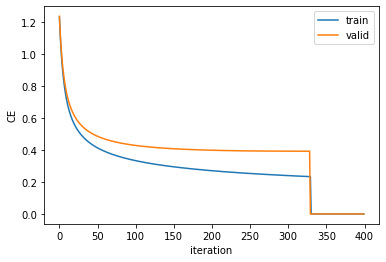

In [59]:
plt.clf()
plt.plot(ce_train[:400]/X_train.shape[0], label='train')
plt.plot(ce_valid[:400]/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.show()

Evaluate the accuracy of the model

In [60]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [61]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

0.9309045226130653
0.8505025125628141
0.8445859872611465


Generate heatmap

In [62]:
# select top 5 words for each class
top_words = np.argsort(mlr.W, axis=0)[-5:, :]
top_words = top_words.flatten()

print(top_words)

[107  27 249 131  28 207 109 179  65  98  84 135 196  17 205 176  69  48
 251  60]


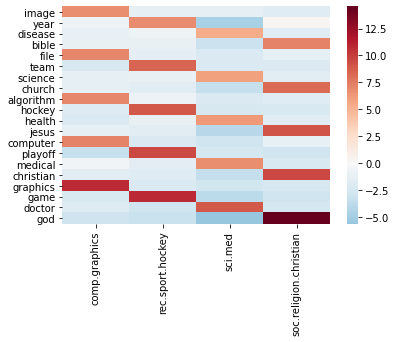

In [63]:
selected_W = mlr.W[top_words]
y_label_words = list()
for i in range(len(top_words)):
    y_label_words.append(features[selected_features[top_words[i]]])
hmp = heatmap(selected_W, cmap='RdBu_r', center=0, yticklabels=y_label_words, xticklabels=dataset.target_names)


In [64]:
print(features[selected_features[84]])

health


Let's compare this with KNN

In [65]:
def fit_KNN(X_train, y_train, X_valid, y_valid):
    accuracies = np.zeros(50)
    for k in range(40):
        knn = KNeighborsClassifier(n_neighbors=k+1)
        pred = knn.fit(X_train, y_train).predict(X_valid)
        accuracies[k] = np.sum(pred == y_valid)
    accuracies = accuracies/X_valid.shape[0]
    best_K = accuracies.argmax() + 1
    return KNeighborsClassifier(n_neighbors=best_K).fit(X_train, y_train)

In [66]:
mlr_accuracies = np.zeros(5)
knn_accuracies = np.zeros(5)
index = 0
for x in [0.2, 0.4, 0.6, 0.8, 1.0]:
    if x == 1.0:
        X_train_tmp, y_train_tmp = X_train, y_train
    else:
            X_train_tmp, _ , y_train_tmp, _ = model_selection.train_test_split(X_train, y_train, train_size= x, random_state=1, shuffle=True)
  # X_valid_tmp, _ , y_valid_tmp, _ = model_selection.train_test_split(X_valid, y_valid, train_size= x, random_state=1, shuffle=True)
    mlr = Multinomial_logistic(X_train_tmp.shape[1], y_train_tmp.shape[1])
    mlr.fit(X_train_tmp, y_train_tmp, X_valid, y_valid, lr = 0.015 ,niter=2000)
    mlr_accuracies[index] = evaluate(mlr.predict(X_test), y_test)
    print("MLR accuracy:", mlr_accuracies[index])
      # convert one-hot-encoding to numbers for KNN
    y_train_tmp_nums = np.argmax(y_train_tmp, axis=1)
    y_valid_tmp_nums = np.argmax(y_valid, axis=1)
    y_test_tmp_nums = np.argmax(y_test, axis=1)

    knn_pred = fit_KNN(X_train_tmp, y_train_tmp_nums, X_valid, y_valid_tmp_nums).predict(X_test)
    knn_accuracies[index] = np.sum(knn_pred == y_test_tmp_nums)/X_test.shape[0]
    print("KNN accuracy:", knn_accuracies[index])
    index += 1

Validation loss just increased at iteration 1430, model has been fitted
MLR accuracy: 0.7248407643312101
KNN accuracy: 0.5095541401273885
Validation loss just increased at iteration 1030, model has been fitted
MLR accuracy: 0.7961783439490446
KNN accuracy: 0.5401273885350318
Validation loss just increased at iteration 1196, model has been fitted
MLR accuracy: 0.8165605095541402
KNN accuracy: 0.5681528662420382
Validation loss just increased at iteration 1023, model has been fitted
MLR accuracy: 0.8280254777070064
KNN accuracy: 0.5949044585987261
Validation loss just increased at iteration 1083, model has been fitted
MLR accuracy: 0.8407643312101911
KNN accuracy: 0.5923566878980892


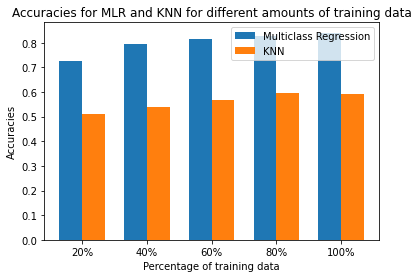

In [67]:
labels = ['20%', '40%', '60%', '80%', '100%']
label_loc = np.arange(len(labels))

width = 0.35
fig, ax = plt.subplots()
ax.bar(label_loc - width/2, mlr_accuracies, width ,label='Multiclass Regression')
ax.bar(label_loc + width/2, knn_accuracies, width, label='KNN')
ax.set_ylabel('Accuracies')
ax.set_title('Accuracies for MLR and KNN for different amounts of training data')
ax.set_xlabel('Percentage of training data')
ax.set_xticks(label_loc)
ax.set_xticklabels(labels)
ax.legend()
# fig.tight_layout()
plt.show()

In [68]:
start = time.perf_counter()
print(test)
end = time.perf_counter()
print('Time elapsed:', end-start, 's')

1.7304714791222776e-10
Time elapsed: 0.00011009999980160501 s
